<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/deep_q_learning_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 121.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
import numpy as np
import matplotlib.pyplot as plt

In [17]:
class LinearClassifier(nn.Module):
  def __init__(self, lr, n_classes, input_dims):
    super(LinearClassifier, self).__init__()

    self.fc1 = nn.Linear(*input_dims, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, n_classes)


    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.CrossEntropyLoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, data):
    layer1 = F.sigmoid(self.fc1(data))
    layer2 = F.sigmoid(self.fc2(layer1))
    layer3 = self.fc3(layer2)

    return layer3

  def learn(self, data, labels):
    self.optimizer.zero_grad()

    data = T.tensor(data).to(self.device)
    labels = T.tensor(labels).to(self.device)

    predictions = self.forward(data)
    cost = self.loss(predictions, labels)

    cost.backward()

    self.optimizer.step()

    return cost

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class LinearDeepQNetwork(nn.Module):
  def __init__(self, lr, n_actions, input_dims):
    super(LinearDeepQNetwork, self).__init__()

    self.fc1 = nn.Linear(*input_dims, 128)
    self.fc2 = nn.Linear(128, n_actions)

    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, data):
    layer1 = F.relu(self.fc1(data))
    actions = self.fc2(layer1)

    return actions

In [4]:
class Agent():
  def __init__(self, input_dims, n_actions, lr=0.0001, gamma=0.99, epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
    self.lr = lr
    self.input_dims = input_dims
    self.n_actions = n_actions
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_dec = eps_dec
    self.eps_min = eps_min
    self.action_space = [i for i in range(n_actions)]

    self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
      state = T.tensor(observation, dtype=T.float).to(self.Q.device)

      actions = self.Q.forward(state)
      action = T.argmax(actions).item()
    else:
      action = np.random.choice(self.action_space)

    return action

  def decrement_epsilon(self):
    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

  def learn(self, state, action, reward, state_):
    self.Q.optimizer.zero_grad()

    states = T.tensor(state, dtype=T.float).to(self.Q.device)

    actions = T.tensor(action).to(self.Q.device)

    rewards = T.tensor(reward).to(self.Q.device)

    states_ = T.tensor(state_, dtype=T.float).to(self.Q.device)

    q_pred = self.Q.forward(states)[actions]

    q_next = self.Q.forward(states_).max()

    q_target = reward + self.gamma*q_next

    loss = self.Q.loss(q_target, q_pred).to(self.Q.device)

    loss.backward()

    self.Q.optimizer.step()

    self.decrement_epsilon()


    q_target = rewards + self.gamma*T.max(q_next)

In [5]:
def plot_learning_curve(x, scores, epsilons, filename):
  fig = plt.figure()
  ax = fig.add_subplot(111, label='1')
  ax2 = fig.add_subplot(111, label='2', frame_on=False)

  ax.plot(x, epsilons, color='C0')
  ax.set_xlabel('Trainig Steps', color='C0')
  ax.set_ylabel('Epsilon', color='C0')
  ax.tick_params(axis='x', color='C0')
  ax.tick_params(axis='y', color='C0')

  N = len(scores)
  running_avg = np.empty(N)

  for t in range(N):
    running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

  ax2.scatter(x, scores, color='C1')
  ax2.axes.get_xaxis().set_visible(False)

  ax2.yaxis.tick_right()
  ax2.set_ylabel('Score', color='C1')
  ax2.yaxis.set_label_position('right')
  ax2.tick_params(axis='y', color='C1')

  plt.savefig(filename)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


episode  0 score 19.00, average score 19.00, epsilon 1.00
episode  100 score 23.00, average score 19.95, epsilon 0.98
episode  200 score 29.00, average score 23.05, epsilon 0.96
episode  300 score 54.00, average score 23.82, epsilon 0.93
episode  400 score 28.00, average score 21.87, epsilon 0.91
episode  500 score 27.00, average score 22.83, epsilon 0.89
episode  600 score 16.00, average score 21.88, epsilon 0.87
episode  700 score 27.00, average score 25.26, epsilon 0.84
episode  800 score 65.00, average score 24.37, epsilon 0.82
episode  900 score 20.00, average score 23.44, epsilon 0.79
episode  1000 score 28.00, average score 22.05, epsilon 0.77
episode  1100 score 14.00, average score 22.85, epsilon 0.75
episode  1200 score 44.00, average score 26.55, epsilon 0.72
episode  1300 score 32.00, average score 26.74, epsilon 0.70
episode  1400 score 17.00, average score 24.64, epsilon 0.67
episode  1500 score 20.00, average score 29.07, epsilon 0.64
episode  1600 score 14.00, average s

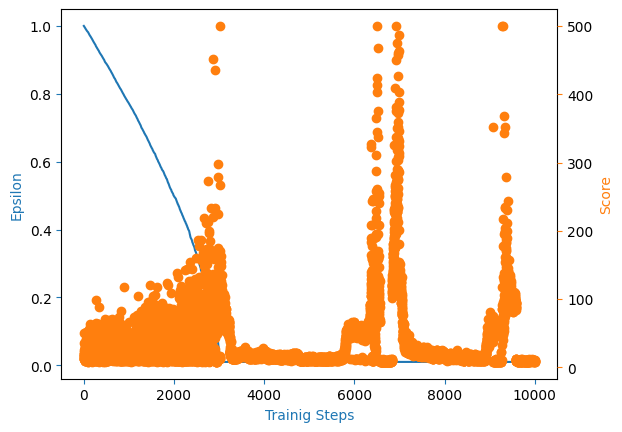

In [6]:
env = gym.make('CartPole-v1')
n_games = 10000
scores = []
eps_history = []

agent = Agent(
    input_dims=env.observation_space.shape,
    n_actions=env.action_space.n)

for i in range(n_games):
  done = False
  score = 0
  obs = env.reset()

  while not done:
    action = agent.choose_action(obs)
    obs_, reward, done, info = env.step(action)
    score += reward
    agent.learn(obs, action, reward, obs_)
    obs = obs_

  scores.append(score)

  eps_history.append(agent.epsilon)

  if i % 100 == 0:
    avg_score = np.mean(scores[-100:])

    print('episode ', i, 'score %.2f, average score %.2f, epsilon %.2f' %
                                      (score, avg_score, agent.epsilon))

filename = 'cart_pole_naive_dqn.png'

x = [i+1 for i in range(n_games)]

plot_learning_curve(x, scores, eps_history, filename)